## 1. Project Overview

### 1.1 Background
-  Booming Chinese movie industry: In the first quarter of 2018, its box office has just overtaken North America (US and Canada combined).
-  American movie industry is trying to tap into Chinese market, but results have been mixed. Example: Black Panther vs Transformers 5: The Last Knight.


### 1.2 Purpose of the project
-  Predict Chinese box office and movie review based on a series of movie characteristics, including *movie genre, movie release year, director and cast popularity, budget, US review count, US IMDB review score, US domestic box office*

## 2. Data source

### 2.1 Webscapping
-  Review data for 7000 movies and TV series scraped from __[IMDB](http://www.imdb.com)__ and __[Douban](http://movie.douban.com/)__, which represent American and Chinese viewers' preferences respectively. 
-  Box office data from __[box office mojo](https://www.boxofficemojo.com/)__, which includes both U.S. domestic and Chinese box office. 
-  Directors and lead cast followers scraped from __[Douban](http://movie.douban.com/)__, which represents cast popularity in China. 
-  Web scrapping was conducted using *__Requests__* package and parsed with *__BeautifulSoup__*.
-  Scraped data was stored in sqlite database.

### 2.2 Extracted features
-  Review counts from Douban and IMDB: *DBreview_count*, *IMDBreview_count*
-  Average review score from Douban and IMDB: *DBratings*, *IMDBratingUS*
-  Box office in U.S. and Chinese market: *Box office domestic*, *Box office CN*
-  Movie genre (one-hot coded)
-  Movie release year: *USrelease*
-  Budget: *budget*
-  Director and lead cast followers: *DR_DB_Followers*, *CAST_DB_Followers*

## 3. Data analysis
### 3.1 Data processing
-  [Data cleaning](#3.1.1)
-  [Currency inflation adjustment](#3.1.2)
-  [Missing data](#3.1.3)

### 3.2 Descriptive analysis
-  [Bivariate scatterplot](#3.2.1)
-  [Multivariate interaction](#3.2.2)
-  [Transformation](#3.2.3)

## 4. Predictive analysis
### 4.1 Prediction of Chinese viewer rating
-  [Feature scaling](#4.1.1)
-  [Building pipeline](#4.1.2)
-  [Regression with linear model and decision tree model](#4.1.3)
### 4.2 Prediction of Chinese box office
-  [Feature scaling](#4.2.1)
-  [Building pipeline](#4.2.2)
-  [Regression with linear model and decision tree model](#4.2.3)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##  3. Data Analysis

### 3.1 Data processing

In [8]:
# Load data 
df=pd.read_csv('Cleaned_data_new.csv')
# Examine columns and column types
# print(df.dtypes)
df.head()

,DBrating,IMDBratingUS,IMDBrating,DBreview_count,IMDBreview_count,Genre,Title,Directors,Casts,Box office domestic,...,Western,News,War,Comedy,Sport,Sci-Fi,Biography,Crime,Drama,All Genre
0,8.2,8.1,8.0,246840,147449,Action/Adventure/Thriller/,Mission: Impossible - Fallout,Christopher McQuarrie,Tom Cruise/Henry Cavill/Ving Rhames/Simon Pegg/,220159104.0,...,False,False,False,False,False,False,False,False,False,True
1,7.4,7.4,7.2,187869,141007,Action/Adventure/Comedy/Sci-Fi/,Ant-Man and the Wasp,Peyton Reed,Paul Rudd/Evangeline Lilly/Michael Peña/Walton...,216648740.0,...,False,False,False,True,False,True,False,False,False,True
2,6.3,6.2,6.1,22171,24070,Action/Adventure/Comedy/,The Spy Who Dumped Me,Susanna Fogel,Justin Theroux/Blanka Györfi-Tóth/Vilma Szécsi...,33562069.0,...,False,False,False,True,False,False,False,False,False,True
3,9.4,8.7,8.8,933844,1532393,Drama/Romance/,Forrest Gump,Robert Zemeckis,Tom Hanks/Robin Wright/Gary Sinise/Sally Field/,329694499.0,...,False,False,False,False,False,False,False,False,True,True
4,9.3,8.7,8.8,953369,1760580,Action/Adventure/Sci-Fi/Thriller/,Inception,Christopher Nolan,Leonardo DiCaprio/Joseph Gordon-Levitt/Ellen P...,292576195.0,...,False,False,False,False,False,True,False,False,False,True


<a id="3.1.1"></a>
Some variables do not have known values from the website. Webscrapping returned some characters other than NaN for these values. I first changed these missing values to NaN.

In [9]:
# change budget zero values to NaN
df['budget'].replace(to_replace=0,value=np.nan,inplace=True)

# change NA values in DR_DB_followers and CAST_DB_followers
cols = ['DR_DB_Followers', 'CAST_DB_Followers']
df.loc[:,cols]= df.loc[:,cols].replace(to_replace=r'^Directors',value=np.nan,regex=True)
df['DR_DB_Followers']=pd.to_numeric(df['DR_DB_Followers'],errors='coerse')
df['CAST_DB_Followers']=pd.to_numeric(df['CAST_DB_Followers'],errors='coerse')

As there are more than 20 types of genres, and some genres are very rare, I will only analyze genres that exist in more than 10% movies.

In [10]:
# Convert Genre type to 0/1
genre_type=['Thriller', 'Musical', 'Mystery',
             'Adventure','Drama', 'News', 'Film-Noir', 'Family', 'Animation', 'Short', 'Sport',
             'Crime', 'Biography', 'Comedy', 'Game-Show', 'Music', 'War', 'Romance','Fantasy', 
             'History', 'Horror', 'Sci-Fi', 'Documentary', 'Western','Action', 'Adult', 'Reality-TV']
df[genre_type] = df[genre_type].astype(int)

# Delete rare genre type: delete if exists in <10% movies
genre_mean = df[genre_type].mean()
popular_genre = genre_mean.index[genre_mean>=0.1].tolist()

The movie release year from webscrapping is not in clean format. I extract the year information from webscapped results.

In [11]:
# Extract year of release
year_regex = '(20[0-9][0-9])|(19[0-9][0-9])'

def extract(x):
    try:
        return list(filter(lambda m:m!='',x[-1]))[0]
    except:
        return None  
df['USrelease'] = df['USrelease'].str.findall(year_regex,flags=0).apply(extract)
df['USrelease'] = pd.to_numeric(df['USrelease'], errors='coerce')

<a id="3.1.2"></a>
Box office and budget from different years are influenced by currency inflation, so I adjusted for the inflation such that they can be compared across movies in different years. 
<bk>
To adjust for inflation, I downloaded the annual average inflation rate from __[inflationdata website](https://inflationdata.com/inflation/Inflation_Rate/HistoricalInflation.aspx)__ and computed the cummulative inflation rate from year 1914 to 2018. Using the year 2000 as the reference year, I transformed the box office and budget values to the US dollar value in 2000. 

In [12]:
# read in inflation data
inflation = pd.read_csv('CurrencyInflationAdjust.csv') 

# Corrected box office and budget based on currency inflation 
df = df.merge(inflation, left_on='USrelease', right_on='Year', how='left') 
df['budget'] = df['budget'] * df['Multiplier']
df['Box office domestic'] = df['Box office domestic'] * df['Multiplier']
df['Box office CN'] = df['Box office CN'] * df['Multiplier']
df['Box office foreign'] = df['Box office foreign'] * df['Multiplier']

<a id="3.1.3"></a>
Missing rate in each variable

In [13]:
colSelect = ['DBrating','Box office CN','IMDBratingUS','Box office domestic', 'Box office foreign',
             'DBreview_count','IMDBreview_count', 'budget','USrelease',
             'DR_DB_Followers', 'CAST_DB_Followers']+ popular_genre
df_na = df[colSelect].isnull().sum()/len(df)
df_na[df_na.values>0].sort_values(ascending=False)

Box office CN          0.867441
Box office foreign     0.485002
budget                 0.216497
DR_DB_Followers        0.115868
CAST_DB_Followers      0.022496
Box office domestic    0.001693
USrelease              0.000242
dtype: float64

The Chinese box office data is only available in 14% movies. This is not surprising due to Chinese movie industry regulation restrictions in early years. The small sample size will likely lead to poor predictions for Chinese box office, but I still want to conduct some exploratory analysis for now. I will only use the 14% sample for Chinese box office analysis. 
<bk>
For the other variables with missing values, I just fill them with median values.

In [14]:
nanfil_list = list(df.columns)  
nanfil_list.remove('Box office CN')
nanfil_list.remove('Box office foreign')# Too many missing values for CN and foreign box office
df[nanfil_list] = df[nanfil_list].fillna(df[nanfil_list].median())

<a id="3.2"></a>
### 3.2 Descriptive analysis

First, I run descriptive statistics to get an understanding of the range of each variable.

In [15]:
# Descriptive statistics
df[colSelect].describe()

,DBrating,Box office CN,IMDBratingUS,Box office domestic,Box office foreign,DBreview_count,IMDBreview_count,budget,USrelease,DR_DB_Followers,...,Adventure,Drama,Family,Crime,Comedy,Romance,Fantasy,Horror,Sci-Fi,Action
count,4134.000000,5.480000e+02,4134.000000,4.134000e+03,2.129000e+03,4.134000e+03,4.134000e+03,4.134000e+03,4134.000000,4134.000000,...,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000
mean,7.329729,4.375408e+07,6.844461,6.088052e+07,1.310649e+08,3.872981e+04,1.173569e+05,4.846177e+07,2003.302371,3059.537756,...,0.207789,0.544751,0.111998,0.193275,0.337929,0.209482,0.142719,0.118045,0.146831,0.241896
std,0.979872,7.531029e+07,1.044749,9.252642e+07,2.090148e+08,7.980678e+04,1.735595e+05,5.544460e+07,16.376336,8941.025636,...,0.405774,0.498054,0.315402,0.394915,0.473062,0.406988,0.349828,0.322701,0.353980,0.428284
min,3.400000,8.710559e+03,1.600000,1.685354e+02,1.016088e+02,6.800000e+01,2.000000e+01,5.223250e+03,1903.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.700000,2.804122e+06,6.200000,4.842240e+06,1.502009e+07,3.034500e+03,1.919950e+04,1.650575e+07,1999.000000,36.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.400000,1.097434e+07,6.900000,3.015682e+07,5.188262e+07,9.204000e+03,6.117050e+04,3.181287e+07,2008.000000,164.666667,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,5.023001e+07,7.600000,7.619782e+07,1.472465e+08,3.369550e+04,1.411630e+05,5.508520e+07,2014.000000,968.750000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.800000,5.594296e+08,10.000000,1.021341e+09,2.527056e+09,1.184569e+06,2.011889e+06,4.683179e+08,2019.000000,75753.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id="3.2.1"></a>
To better visualize the distribution of each continuous variable, and their correlation with target variables- review score from douban(*DBrating*) and Chinese box office (*Box office CN*), the scatterplot are made for each continuous variables with the target variables. 
<bk>
As Chinese box office is only available in 14% sample, its relationship with continuous predictors is run a on seperate sample from douban review scores. However, douban review scores showed similar patterns in both samples, so only one scatterplot that includes Chinese box office is shown here.

In [16]:
df_CN = df[df['Box office CN'].notnull()].copy() # A copy of dataset containing movies with Chinese box office data

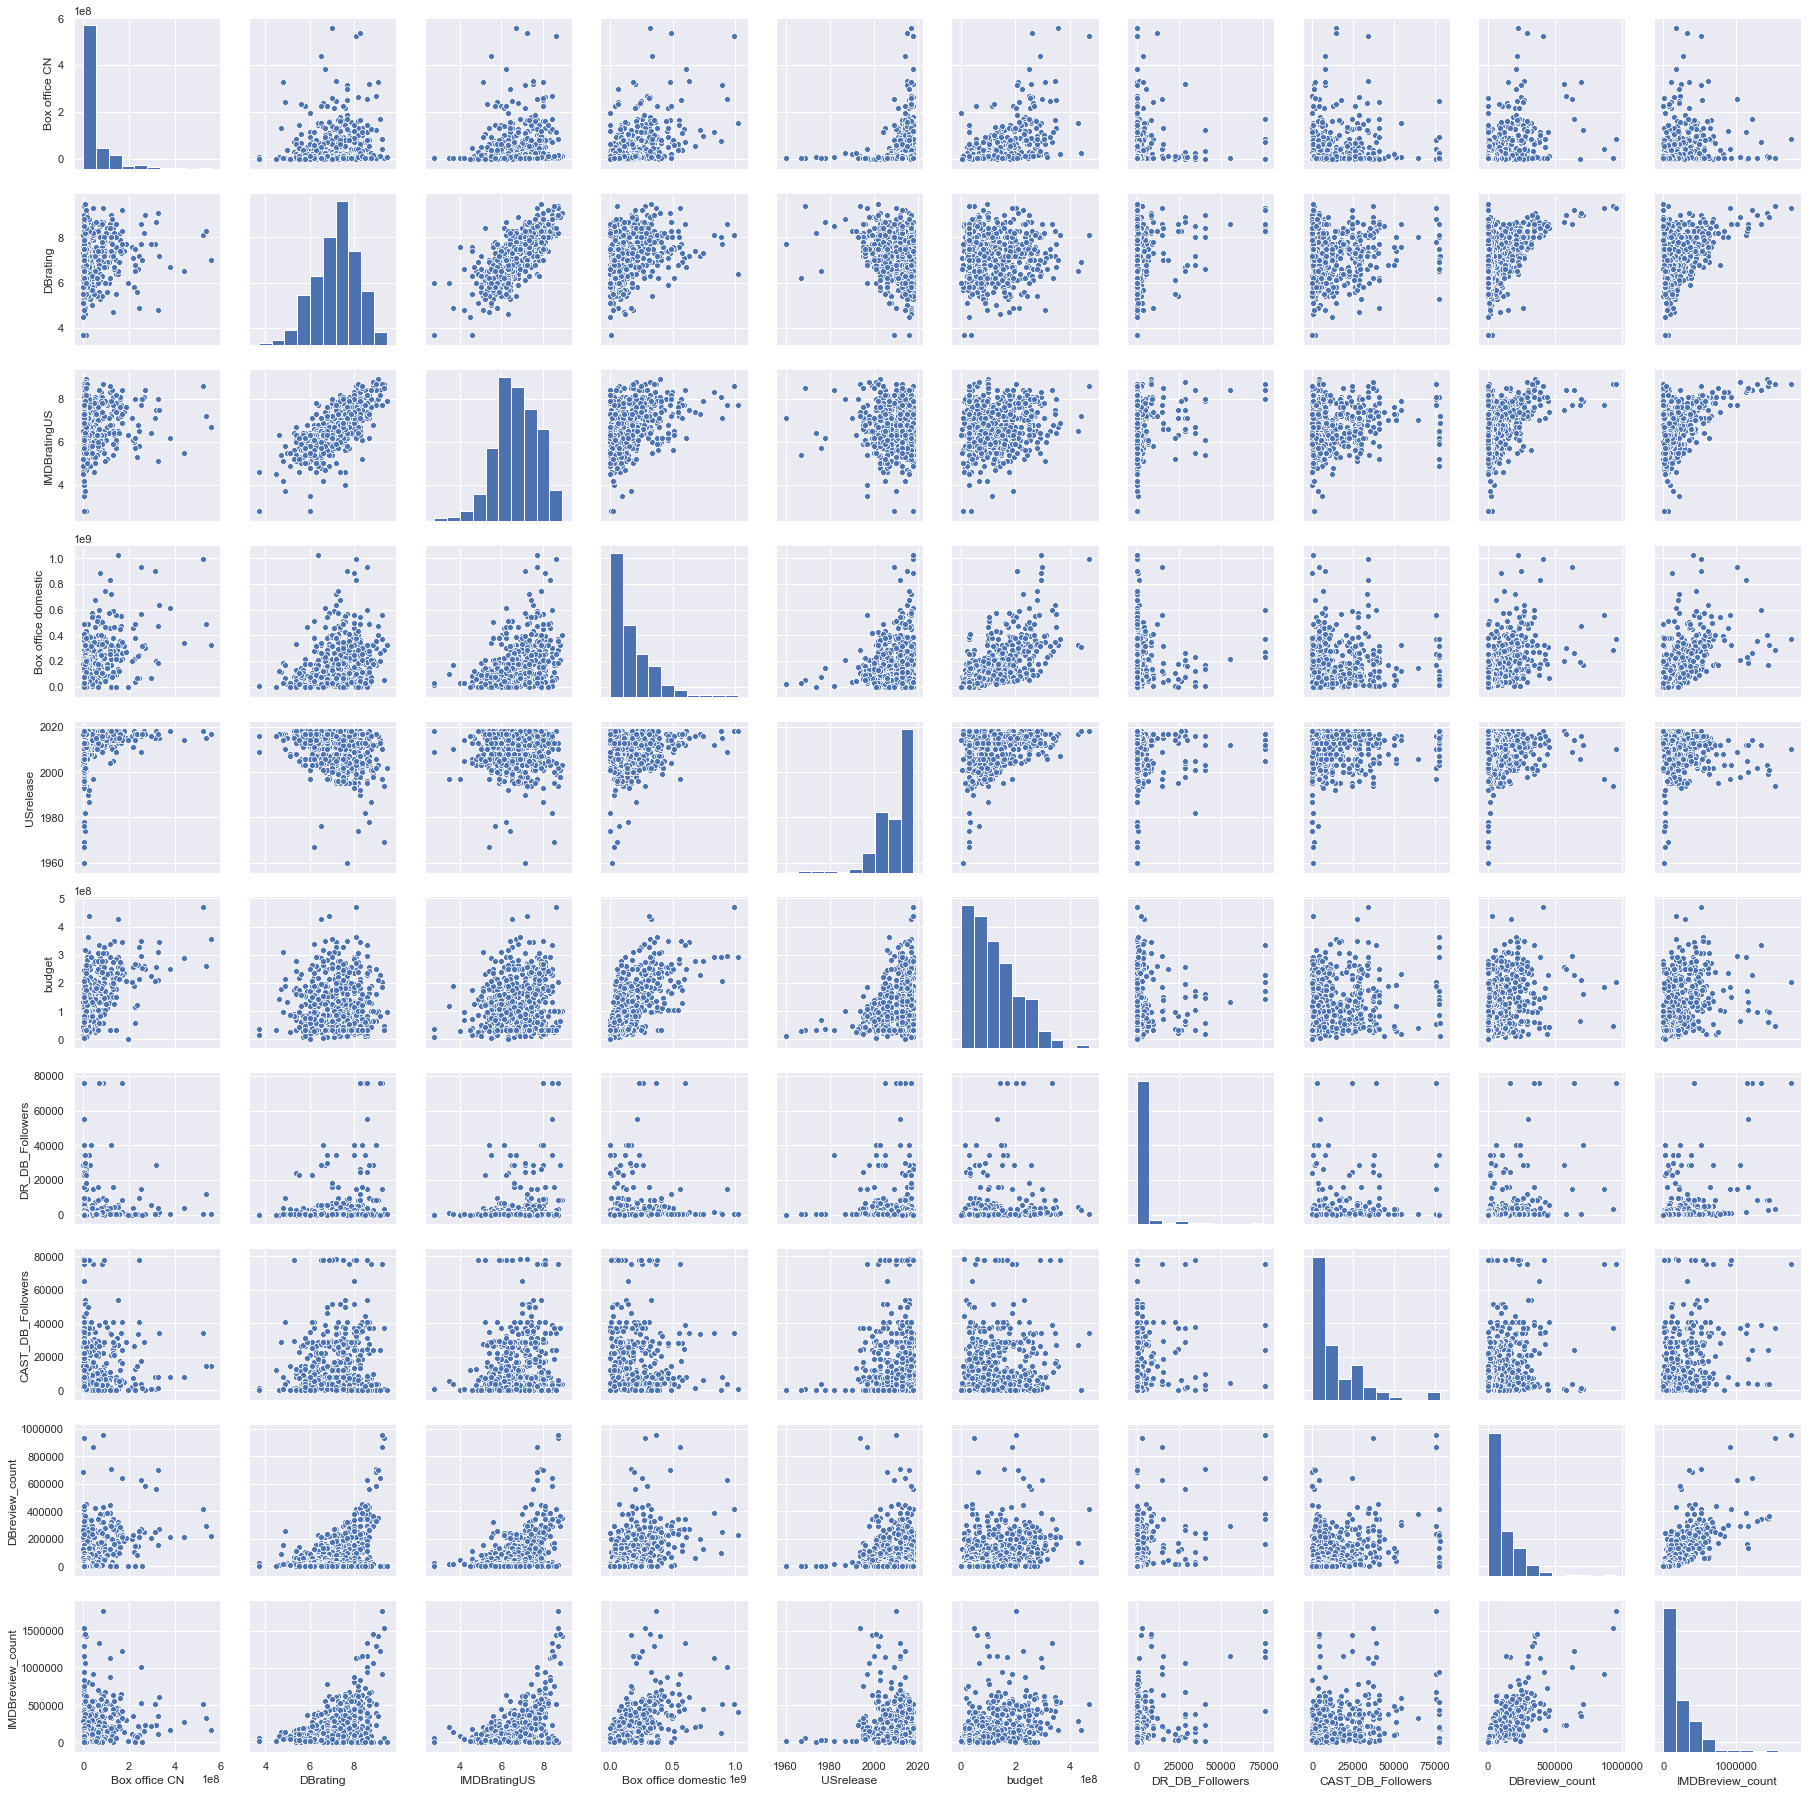

In [17]:
cols = ['Box office CN','DBrating','IMDBratingUS', 'Box office domestic','USrelease','budget',
        'DR_DB_Followers', 'CAST_DB_Followers','DBreview_count', 'IMDBreview_count']
sns.set(color_codes=True)
sns.pairplot(df_CN[cols])

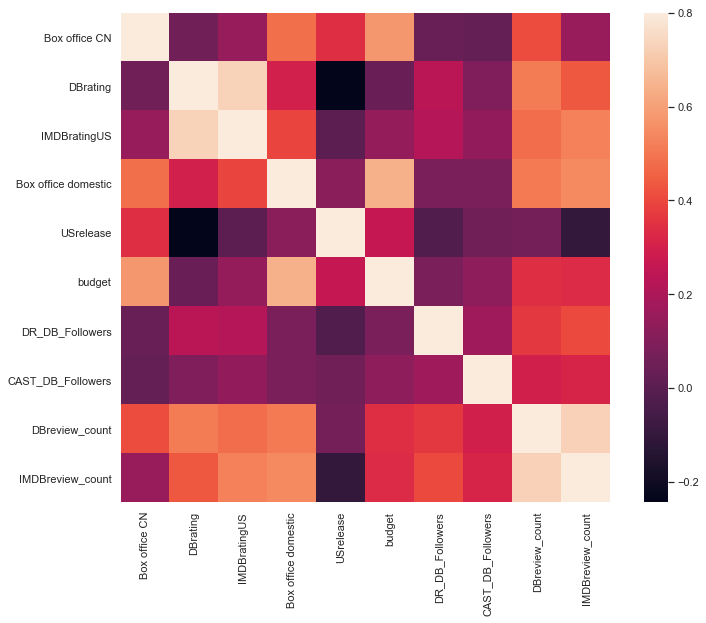

In [18]:
corrmat = df_CN[cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Key findings from the scatterplot:
-  For Douban review scores:
    -  Douban review score is highly correlated with  IMDB review . 
    -  Review score has an increasing pattern with  review counts, US domestic box office , but has large variance when these variables have small values.
    -  Review score has a weak increasing pattern with the  cast popularity : there is a large variance in review scores for low-popularity cast.
    -  Review score does not seem to to have a meaningful pattern with  budget  and  release year .
-  For Chinese box office:
    -  It does not have a linear relationship with  review score  or  budget 
    -  It seems to have an increasing pattern with  US domestic box office  and  release year 
    -  It does not have a meaningful pattern with  cast popularity  or  review count 

<a id="3.2.2"></a>
Now I added the categorical variables, *genre type*, to see whether it has any relationship with the target variables, and whether it has an interaction effect with some of the continuous variables.

As both douban review score and Chinese box office do not have a clear pattern with budget or cast popularity, which is somewhat unexpected, I looked at the interaction between Top4 most popular genres and budge/cast popularity, to see whether added interaction terms could help form a pattern.

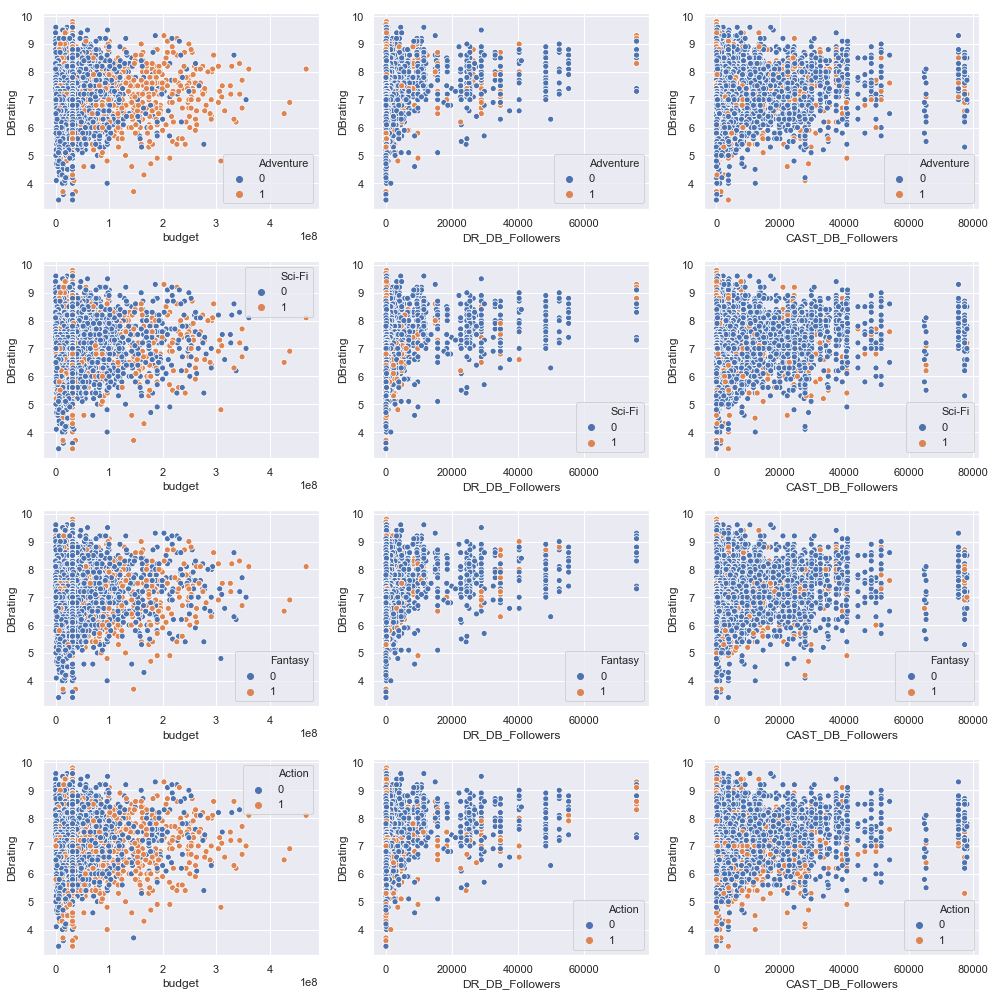

In [19]:
genre_top4 = ['Adventure', 'Sci-Fi', 'Fantasy', 'Action']

plt.figure(figsize=(14,14))
for i, g in enumerate(genre_top4):
    ax1 = plt.subplot(4,3,1+3*i)
    sns.scatterplot(x='budget', y='DBrating', hue=g,
            data=df, ax=ax1)
    ax2 = plt.subplot(4,3,2+3*i)
    sns.scatterplot(x='DR_DB_Followers', y='DBrating', hue=g,
            data=df, ax=ax2)
    ax3 = plt.subplot(4,3,3+3*i)
    sns.scatterplot(x='CAST_DB_Followers', y='DBrating', hue=g,
            data=df, ax=ax3)
plt.tight_layout()

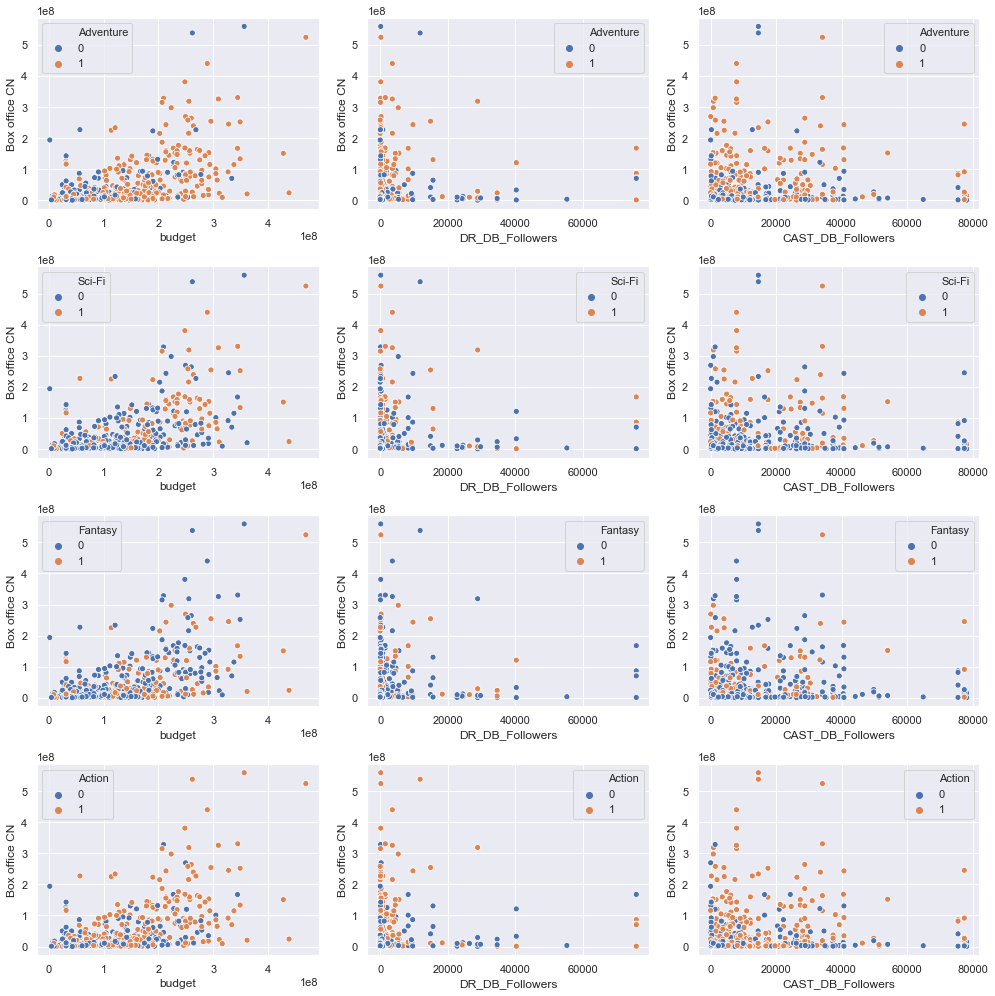

In [20]:
plt.figure(figsize=(14,14))
for i, g in enumerate(genre_top4):
    ax1 = plt.subplot(4,3,1+3*i)
    sns.scatterplot(x='budget', y='Box office CN', hue=g,
            data=df_CN, ax=ax1)
    ax2 = plt.subplot(4,3,2+3*i)
    sns.scatterplot(x='DR_DB_Followers', y='Box office CN', hue=g,
            data=df_CN, ax=ax2)
    ax3 = plt.subplot(4,3,3+3*i)
    sns.scatterplot(x='CAST_DB_Followers', y='Box office CN', hue=g,
            data=df_CN, ax=ax3)
plt.tight_layout()

There seems to be either no interaction between the genre and budget/cast popularity, or no association between the Top4 genres with  douban review score/Chinese box office. 
-  This analysis suggests there might be no need to create interaction terms between movie genre and other continuous variables.

<a id="3.2.3"></a>
Exploration of some transformations
-  The scatterplot suggests douban rating seems to have a non-linear pattern with US domestic box office and review count. I performed log transformation on the US domestic box and review count.
-  I also noticed many variables have skewed distributions. As the purpose here is to make predictions (*which is less affected by the skewness*) instead of making statistical inference or interpretation of the linear regression coefficient(*which are more likely to be affected by the skewness*). I did not perform transformations to correct for skewness.

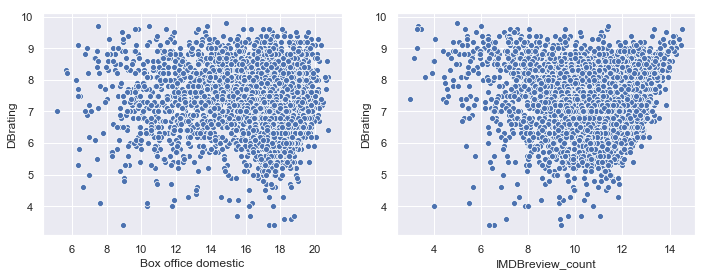

In [21]:
# Log transformation on US domestic box and review count
plt.figure(figsize=(10,4))
log_cols = ['Box office domestic', 'IMDBreview_count']
df_log = df.copy()
df_log[log_cols]=np.log(df_log[log_cols])

ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=log_cols[0], y='DBrating', data=df_log, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(x=log_cols[1], y='DBrating', data=df_log, ax=ax2)
plt.tight_layout()

Log transformation does not work very well, so I will leave the two variables untransformed and keep in in mind that the linear regression may not work well due to the nonlinear relationship. 

Outlier Analysis

- The scatterplot suggests there are some outliers in many variables, so I plotted boxplot for each variable.

## 4. Predictive analysis
The first objective is prediction of movie ratings of Chinese viewers using budget, director and lead cast followers, IMDB rating and IMDB review count, domestic box office. This represents the senario of a movie that is on screen in US and Chinese viewers have not yet watched the movie. What we're predicting is weather Chinese viewers would like the film.

The second objective is prediction of Chinese box office using the same features plut DBrating and DBreview_count. This represents the senario that some viewers have watched the movie through certain sources and we're trying to predict the box office performance using their response. 

In [27]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn_features.transformers import DataFrameSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.pipeline import Pipeline

### 4.1 Prediction of Chinese viewer rating

<a id="4.1.1"></a>

In [28]:
# Scaling of features
df['CAST_DB_Followers'] = df['CAST_DB_Followers']/1000
df['DR_DB_Followers'] = df['DR_DB_Followers']/1000
df['Box office domestic'] = df['Box office domestic']/10**6
df['budget'] = df['budget']/10**6
df['IMDBreview_count'] = df['IMDBreview_count']/1000

<a id="4.1.2"></a>

In [30]:
# Split dataset into training and testing set
y = df['DBrating'].values
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)

# columns of numerical and categorical values that will be used as features in the model
col_num = ['budget', 'IMDBratingUS', 'IMDBreview_count', 'Box office domestic',
          'DR_DB_Followers', 'CAST_DB_Followers']
col_cat = popular_genre

# Build a pipeline that involves selecting the features from the DataFrame, imputation and regression. Two methods were used
df_features = DataFrameSelector(col_num+col_cat)
imputer = Imputer(strategy='median')
TreeRegressor = DecisionTreeRegressor()
LNRegressor = LinearRegression()

<a id="4.1.3"></a>
Prediction with simple linear regression model

In [31]:
pipe1 = Pipeline([('selector', df_features), ('imputation', imputer), ('regressor', LNRegressor)])
pipe1.fit(X_train, y_train)
print("R_square for training set:", pipe1.score(X_train, y_train))
print("R_square for test set:", pipe1.score(X_test, y_test))

R_square for training set: 0.6028944471100963
R_square for test set: 0.5937144642161785


Prediction with decision tree model

In [32]:
pipe2 = Pipeline([('selector', df_features), ('imputation', imputer), ('regressor', TreeRegressor)])
pipe2.set_params(regressor__max_depth=8, regressor__min_samples_split=7).fit(X_train, y_train)
print("R_square for training set:", pipe2.score(X_train, y_train))
print("R_square for test set:", pipe2.score(X_test, y_test))

R_square for training set: 0.7133136460749845
R_square for test set: 0.5161700645135712


### 4.2 Prediction of Chinese box office

<a id="4.2.1"></a>

In [33]:
# Scaling of features for df_CN
df_CN['CAST_DB_Followers'] = df_CN['CAST_DB_Followers']/1000
df_CN['DR_DB_Followers'] = df_CN['DR_DB_Followers']/1000
df_CN['Box office domestic'] = df_CN['Box office domestic']/10**6
df_CN['budget'] = df_CN['budget']/10**6
df_CN['IMDBreview_count'] = df_CN['IMDBreview_count']/1000
df_CN['DBreview_count'] = df_CN['DBreview_count']/1000
df_CN['Box office CN'] = df_CN['Box office CN']/10**6

<a id="4.2.2"></a>

In [34]:
# Split dataset into training and testing set
y = df_CN['Box office CN'].values
X_train, X_test, y_train, y_test = train_test_split(df_CN, y, test_size=0.2, random_state=0)

# columns of numerical and categorical values that will be used as features in the model
col_num = ['budget', 'IMDBratingUS', 'IMDBreview_count', 'Box office domestic',
          'DR_DB_Followers', 'CAST_DB_Followers', 'DBreview_count', 'DBrating']
col_cat = popular_genre

# Build a pipeline that involves selecting the features from the DataFrame, imputation and regression. Two methods were used
df_features = DataFrameSelector(col_num+col_cat)
imputer = Imputer(strategy='median')
TreeRegressor = DecisionTreeRegressor()
LNRegressor = LinearRegression()

<a id="4.2.3"></a>
Prediction with simple linear regression model

In [35]:
pipe1 = Pipeline([('selector', df_features), ('imputation', imputer), ('regressor', LNRegressor)])
pipe1.fit(X_train, y_train)
print("R_square for training set:", pipe1.score(X_train, y_train))
print("R_square for test set:", pipe1.score(X_test, y_test))

R_square for training set: 0.5055232205892379
R_square for test set: 0.6950981975057894


Prediction with decision tree model

In [36]:
pipe2 = Pipeline([('selector', df_features), ('imputation', imputer), ('regressor', TreeRegressor)])
pipe2.set_params(regressor__max_depth=4, regressor__min_samples_split=2).fit(X_train, y_train)
print("R_square for training set:", pipe2.score(X_train, y_train))
print("R_square for test set:", pipe2.score(X_test, y_test))

R_square for training set: 0.7483091716659951
R_square for test set: 0.5083089556860991
